# Quickstart
* [tutorial](http://lightkurve.keplerscience.org/tutorials/1.02-target-pixel-files.html)

In [4]:
from os.path import join
import getpass
uname = getpass.getuser()

if uname == 'prometheus' or uname == 'jp':
    data_dir = join('/home/',uname,'data/transit/c16-tpf')
elif uname == 'muscat':
    data_dir = '../c16-tpf'
else:
    data_dir = '.'

To install the forked version of lightkurve with a simple patch:

In [5]:
import matplotlib.pyplot as pl
%matplotlib inline

import os
from glob import glob
import numpy as np
from astropy.io import fits
import pandas as pd

In [6]:
file_list = glob(data_dir+'/*.fits')
file_list.sort()
len(file_list)

10

Test

In [4]:
from lightkurve import KeplerTargetPixelFile

i = file_list[2]
tpf = KeplerTargetPixelFile(i, quality_bitmask='hardest')

In [5]:
np.sum(tpf.pipeline_mask)

0

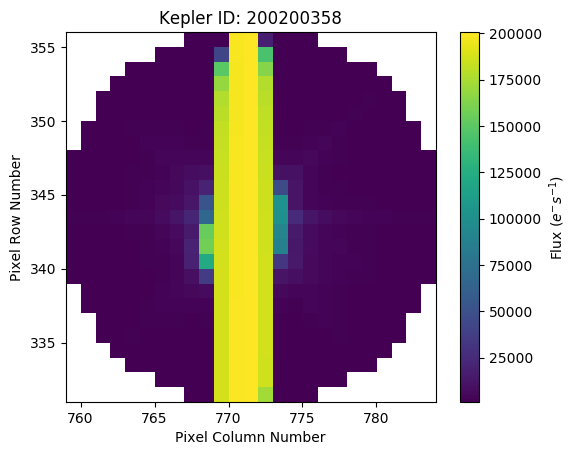

In [6]:
ax = tpf.plot(aperture_mask=tpf.pipeline_mask, mask_color='b', frame=300,
              scale='linear', cmap='viridis', show_colorbar=True)

Pipeline mask is none, so 'all' pixels are used in generating lightcurve.

In [36]:
lc = tpf.to_lightcurve(aperture_mask='all');
lc = lc.remove_nans().remove_outliers(sigma=3)
flat_lc, trend = lc.flatten(window_length=301, return_trend=True)

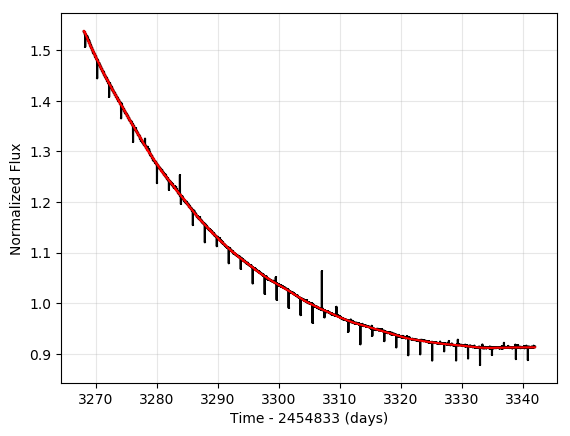

In [37]:
ax = lc.plot()                         
trend.plot(ax, color='red');

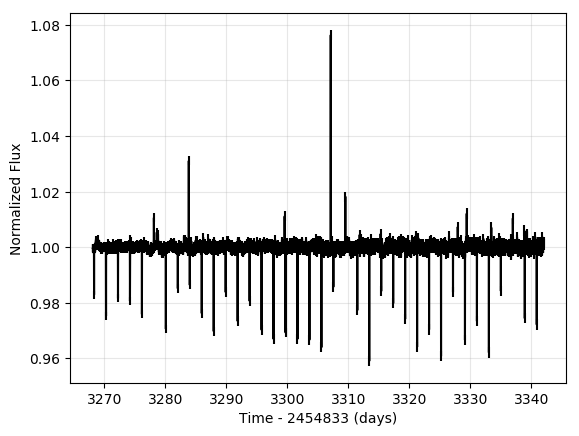

In [38]:
flat_lc.plot();

## Using van Eylen `find_aperture`

In [39]:
from matplotlib.colors import LogNorm
from scipy.ndimage import measurements
import os

cmap='viridis'

def make_aperture_outline(frame, no_combined_images=1, threshold=0.5):
    ## this is a little module that defines so called outlines to be used for plotting apertures

    thres_val = no_combined_images * threshold
    mapimg = (frame > thres_val)
    ver_seg = np.where(mapimg[:,1:] != mapimg[:,:-1])
    hor_seg = np.where(mapimg[1:,:] != mapimg[:-1,:])

    l = []
    for p in zip(*hor_seg):
        l.append((p[1], p[0]+1))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan,np.nan))

    # and the same for vertical segments
    for p in zip(*ver_seg):
        l.append((p[1]+1, p[0]))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan, np.nan))


    segments = np.array(l)

    x0 = -0.5
    x1 = frame.shape[1]+x0
    y0 = -0.5
    y1 = frame.shape[0]+y0

    #   now we need to know something about the image which is shown
    #   at this point let's assume it has extents (x0, y0)..(x1,y1) on the axis
    #   drawn with origin='lower'
    # with this information we can rescale our points
    segments[:,0] = x0 + (x1-x0) * segments[:,0] / mapimg.shape[1]
    segments[:,1] = y0 + (y1-y0) * segments[:,1] / mapimg.shape[0]

    return segments

def find_aperture(dates,fluxes,starname='',outputfolder='',kepmag='na',cutoff_limit=1.,showfig=None):
    #
    # This definition reads a 2D array of fluxes (over time) and creates an aperture mask which can later be used to select those pixels for inclusion in light curve
    #

    # first sum all the flux over the different times, this assumes limited movement throughout the time series
    flux = np.nansum(fluxes,axis=0)

    # define which cutoff flux to use for including pixel in mask
    cutoff = cutoff_limit*np.median(flux) # perhaps a more elaborate way to define this could be found in the future but this seems to work pretty well.

    # define the aperture based on cutoff and make it into array of 1 and 0
    aperture =  np.array([flux > cutoff]) #scipy.zeros((np.shape(flux)[0],np.shape(flux)[1]), int)
    aperture = np.array(1*aperture)
    #print aperture
    outline_all = make_aperture_outline(aperture[0]) # an outline (ONLY for figure) of what we are including if we would make no breakups

    # this cool little trick allows us to measure distinct blocks of apertures, and only select the biggest one
    lw, num = measurements.label(aperture) # this numbers the different apertures distinctly
    area = measurements.sum(aperture, lw, index=np.arange(lw.max() + 1)) # this measures the size of the apertures
    aperture = area[lw].astype(int) # this replaces the 1s by the size of the aperture
    aperture = (aperture >= np.max(aperture))*1 # remake into 0s and 1s but only keep the largest aperture

    outline = make_aperture_outline(aperture[0]) # a new outline (ONLY for figure)

    if showfig: # make aperture figure
        pl.figure('Aperture_' + str(starname))
        pl.imshow(flux,norm=LogNorm(),interpolation="none",cmap=cmap)
        pl.plot(outline_all[:, 0], outline_all[:, 1],color='green', zorder=10, lw=2.5)
        pl.plot(outline[:, 0], outline[:, 1],color='red', zorder=10, lw=2.5)#,label=str(kepmag))
        #pl.colorbar(orientation='vertical')
        pl.xlabel('X',fontsize=15)
        pl.ylabel('Y',fontsize=15)
        #pl.legend()
        #pl.xlim([-1,18])
        #pl.ylim([-1,16])
        #pl.xticks([0,5,10,15])
        #pl.yticks([0,5,10,15])
        pl.tight_layout()
    #pl.savefig(os.path.join(outputfolder,'aperture_' + str(starname)+'.pdf'))
    #pl.close()
    #pl.show()
    return np.array(aperture[0],dtype=bool)

def noise_statistic(t, f, timescale=0.25, verbose=False):
    nchunks = int((t[-1]-t[0])/timescale)+1
    idx = [(t > t[0] + n * timescale) & (t < t[0] + (n + 1) * timescale) for n in range(nchunks)]
    chunks = [f[ix] for ix in idx if ix.sum() > 1]
    
    cdpp = np.std([np.nanmedian(ch) for ch in chunks])
    
    if verbose:
        print('cdpp = {:.4f}'.format(cdpp))
    
    return cdpp

In [40]:
times = tpf.time
fluxes = tpf.flux
aperture = find_aperture(times,fluxes,starname=tpf.keplerid)

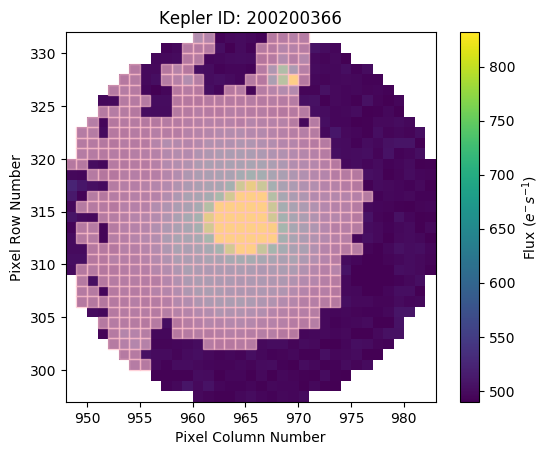

In [41]:
tpf.plot(aperture_mask=aperture)

In [42]:
lc2 = tpf.to_lightcurve(aperture_mask=aperture);
lc2 = lc2.remove_nans().remove_outliers(sigma=3.5)

In [44]:
lc2 = lc2.remove_nans().remove_outliers(sigma=3)
flat_lc2, trend = lc2.flatten(window_length=301, return_trend=True)

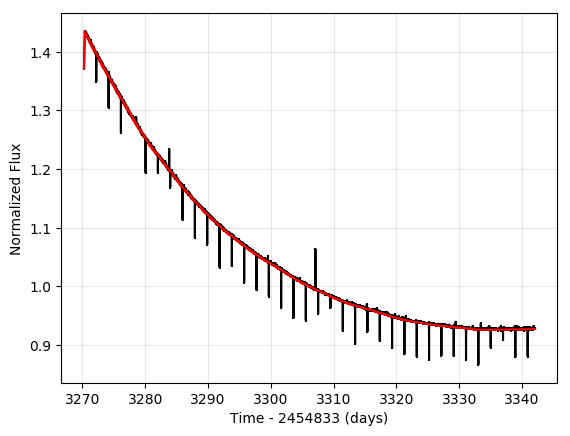

In [45]:
ax = lc2.plot()                         
trend.plot(ax, color='red');

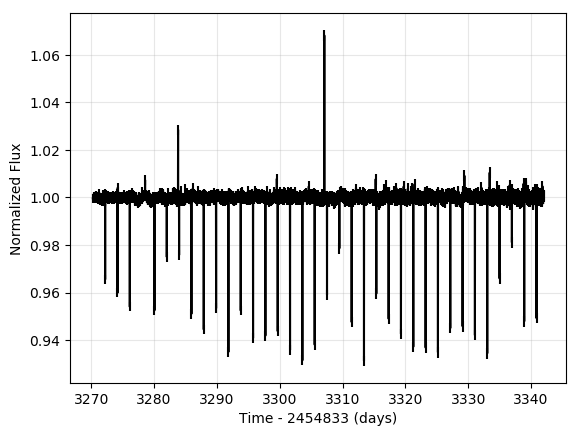

In [46]:
flat_lc2.plot();

In [47]:
corr_lc = lc2.correct(windows=30)

100%|██████████| 30/30 [00:00<00:00, 34.37it/s]


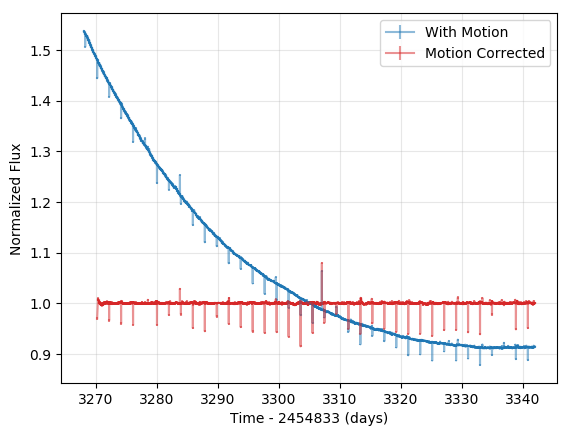

In [48]:
ax = lc.plot(color='C0', alpha=0.5, label='With Motion')
ax = corr_lc.plot(ax=ax, color='C3', alpha=0.5, label='Motion Corrected');

## Period search

In [49]:
from gatspy.periodic import LombScargleFast

model=LombScargleFast(fit_period=True)

model.optimizer.period_range = (1, 10)

model.fit(flat_lc.time, flat_lc.flux, flat_lc.flux_err)

Finding optimal frequency:
 - Estimated peak width = 0.085
 - Using 5 steps per peak; omega_step = 0.017
 - User-specified period range:  1 to 10
 - Computing periods at 334 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


In [50]:
model.best_period

1.9611773359127873

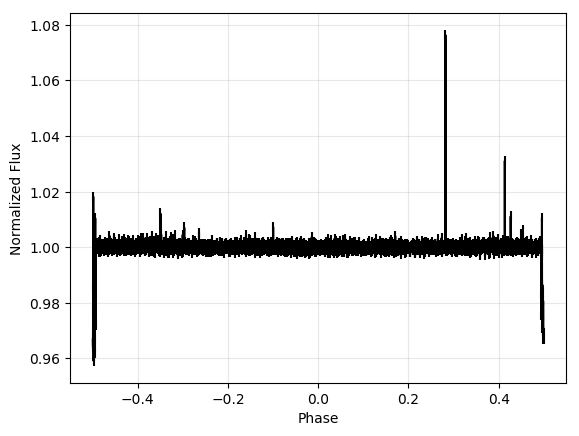

In [51]:
folded_lc = flat_lc.fold(period=model.best_period)
folded_lc.plot();

# Vdb data

# C16 data

100%|██████████| 11/11 [00:00<00:00, 21.07it/s]


cdpp = 0.0020


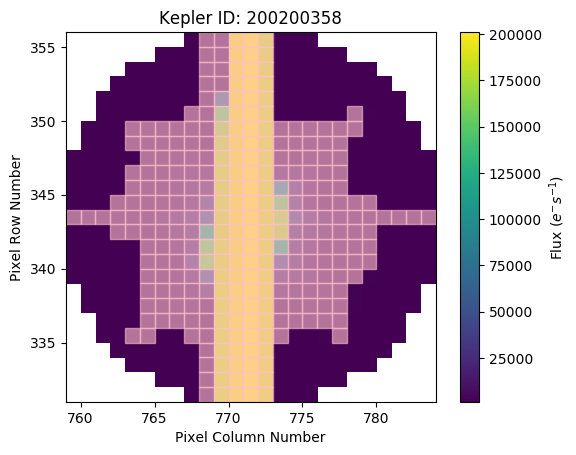

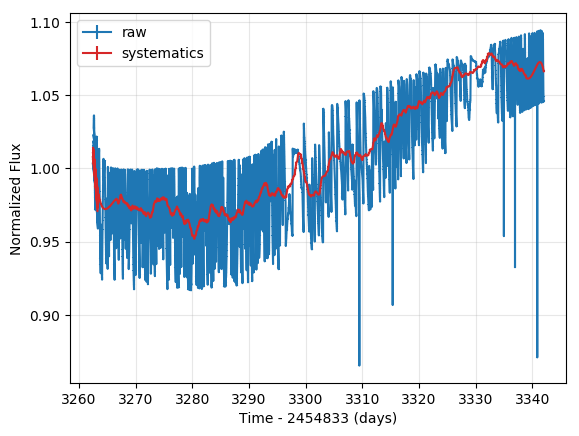

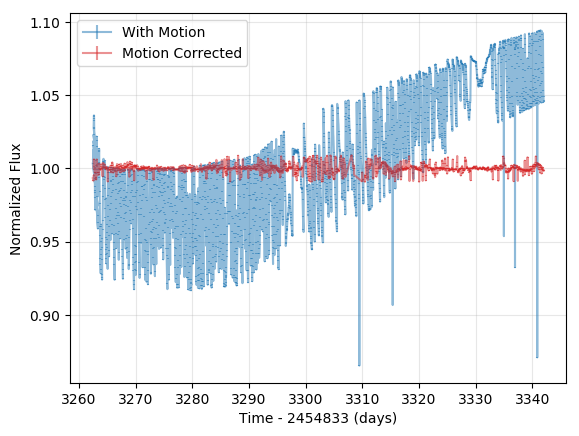

In [54]:
from lightkurve import KeplerTargetPixelFile

sigma = 3
flat_window = 301
corr_window = 11
cutoff_limit = 1.1
polyorder=4
break_tolerance=5

i = file_list[2]
#read tpf
tpf = KeplerTargetPixelFile(i, quality_bitmask='hardest')

times, fluxes = tpf.time, tpf.flux
#confirm aperture
aperture = find_aperture(times,fluxes,cutoff_limit=cutoff_limit,starname=tpf.keplerid)
tpf.plot(aperture_mask=aperture)
#convert to lightcurve
lc = tpf.to_lightcurve(aperture_mask=aperture)
#clean 
lc = lc.remove_nans().remove_outliers(sigma=sigma)
#correcting for low freq variability
flat_lc, trend = lc.flatten(window_length=flat_window,
                            polyorder=polyorder,
                            break_tolerance=break_tolerance, 
                            return_trend=True)
ax = lc.plot(color='C0', label='raw')                         
trend.plot(ax=ax, color='C3',label='systematics');
#correct for systematics using sff
corr_lc = lc.correct(windows=corr_window, method='sff')
corr_lc = corr_lc.remove_outliers(sigma)
#comparison
ax2 = lc.plot(color='C0', alpha=0.5, label='With Motion')
corr_lc.plot(ax=ax2, color='C3', alpha=0.5, label='Motion Corrected');

cdpp = noise_statistic(corr_lc.time, corr_lc.flux, verbose=True)

In [55]:
len(file_list)

10

100%|██████████| 51/51 [00:01<00:00, 42.02it/s]


cdpp = 0.0035


100%|██████████| 51/51 [00:01<00:00, 40.58it/s]


cdpp = 0.0008


100%|██████████| 51/51 [00:01<00:00, 42.71it/s]


cdpp = 0.0022


100%|██████████| 51/51 [00:01<00:00, 40.32it/s]


cdpp = 0.0023


 49%|████▉     | 25/51 [00:00<00:00, 43.28it/s]/home/prometheus/miniconda3/envs/astroconda/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:571: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/prometheus/miniconda3/envs/astroconda/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:574: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/prometheus/miniconda3/envs/astroconda/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:158: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/home/prometheus/miniconda3/envs/astroconda/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:159: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value



/home/prometheus/data/transit/c16-tpf/ktwo200200360-unofficial-tpf.fits


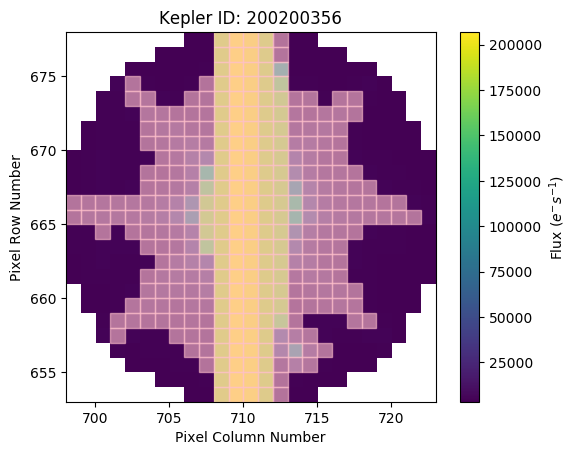

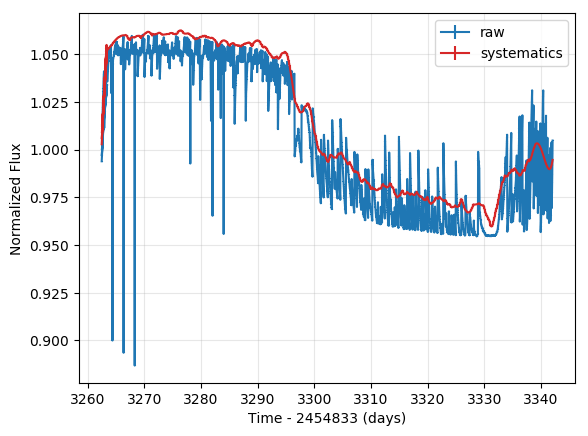

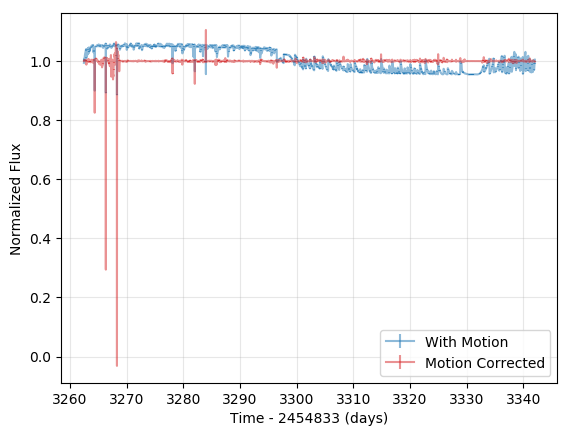

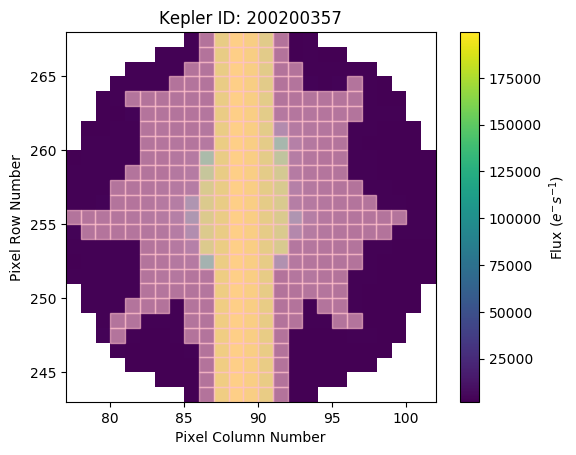

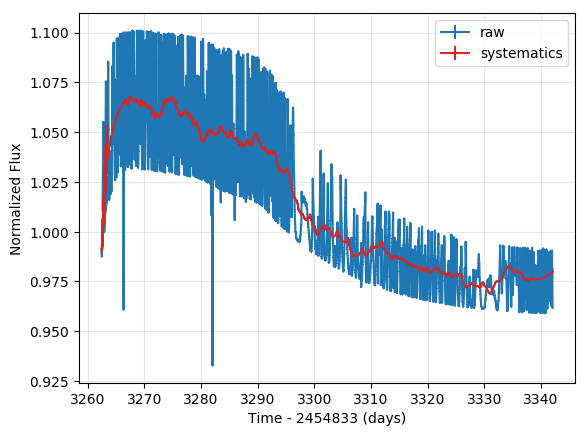

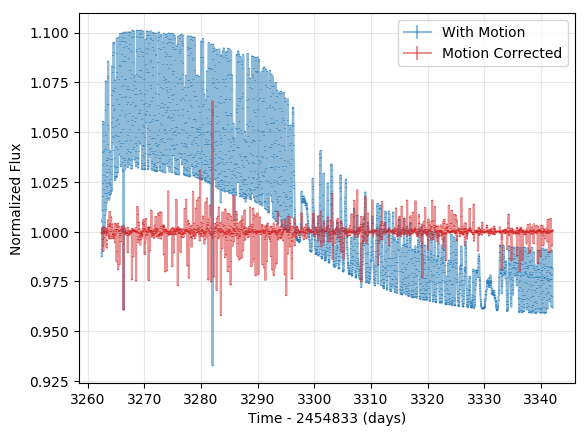

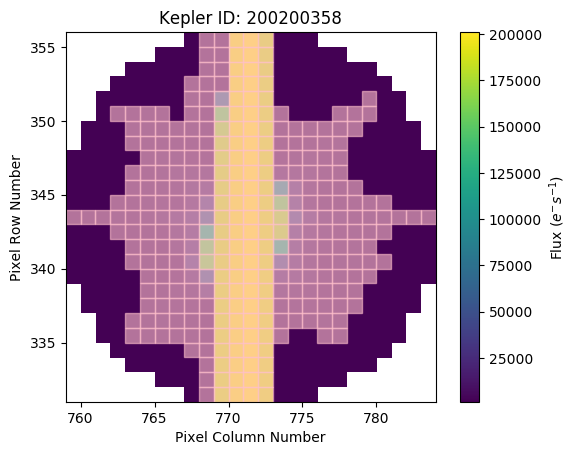

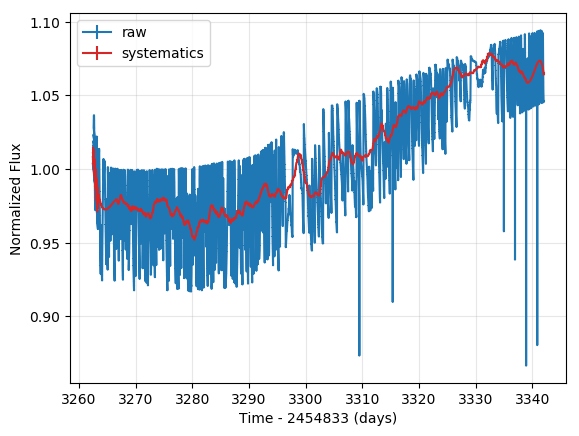

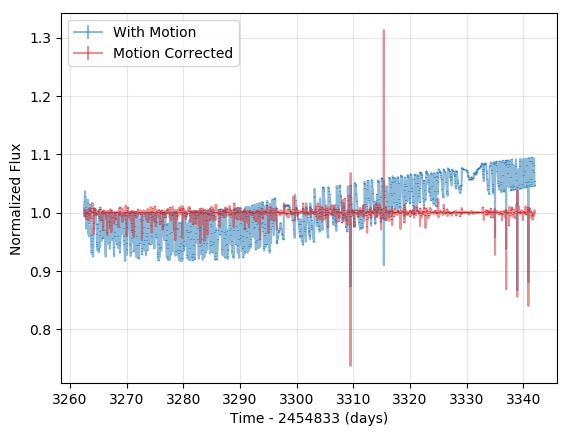

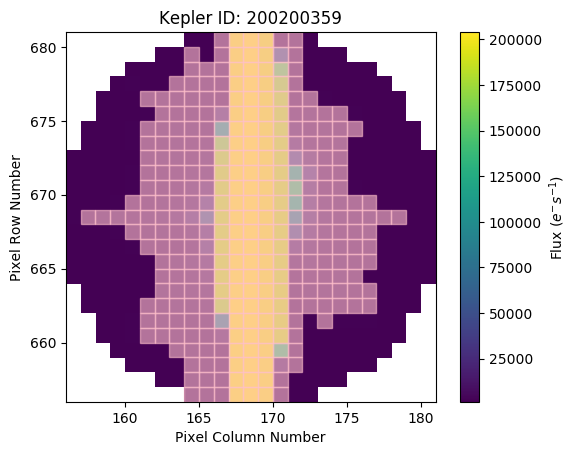

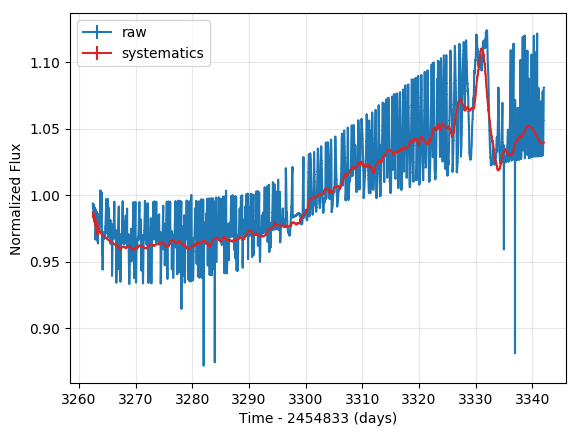

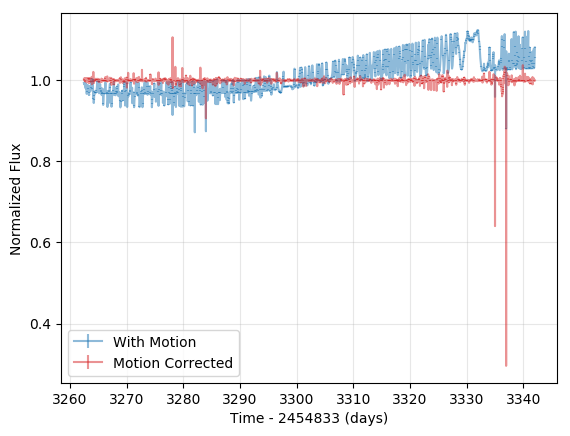

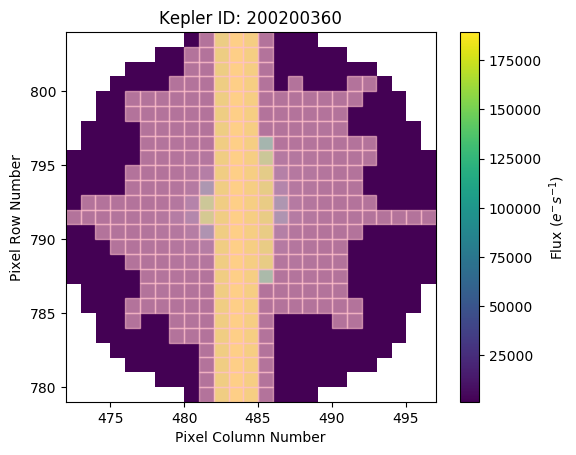

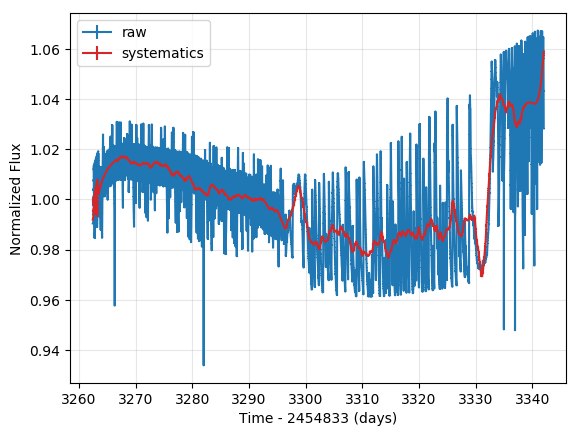

In [56]:
sigma = 3
flat_window = 301
corr_window = 51
cutoff_limit = 1.0
polyorder=4
break_tolerance=5

for i in file_list[:5]:
    try:
        #read tpf
        tpf = KeplerTargetPixelFile(i, quality_bitmask='hardest')
        #confirm aperture
        times, fluxes = tpf.time, tpf.flux
        aperture = find_aperture(times,fluxes,starname=tpf.keplerid)
        tpf.plot(aperture_mask=aperture)
        #convert to lightcurve
        lc = tpf.to_lightcurve(aperture_mask=aperture)
        #clean 
        lc = lc.remove_nans().remove_outliers(sigma=sigma)
        #correcting for low freq variability
        flat_lc, trend = lc.flatten(window_length=flat_window,
                            polyorder=polyorder,
                            break_tolerance=break_tolerance, 
                            return_trend=True)
        ax = lc.plot(color='C0', label='raw')                         
        trend.plot(ax=ax, color='C3',label='systematics');
        #correct for systematics using sff
        corr_lc = lc.correct(windows=corr_window, method='sff')
        
        #corr_lc = corr_lc.remove_outliers(sigma=10)
        #comparison
        ax2 = lc.plot(color='C0', alpha=0.5, label='With Motion')
        corr_lc.plot(ax=ax2, color='C3', alpha=0.5, label='Motion Corrected');
        
        cdpp = noise_statistic(corr_lc.time, corr_lc.flux,verbose=True)
    except:
        print(i)

100%|██████████| 51/51 [00:01<00:00, 43.67it/s]


cdpp = 0.0014


100%|██████████| 51/51 [00:01<00:00, 35.59it/s]


cdpp = 0.0093


100%|██████████| 51/51 [00:01<00:00, 40.52it/s]


cdpp = 0.0711


100%|██████████| 51/51 [00:01<00:00, 39.80it/s]


cdpp = 0.0075


100%|██████████| 51/51 [00:01<00:00, 41.02it/s]


cdpp = 0.0013


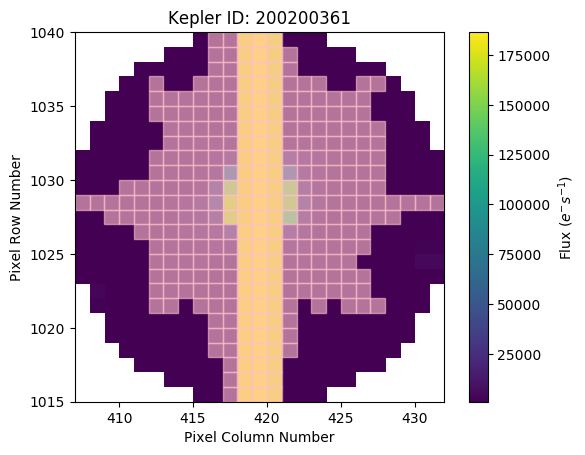

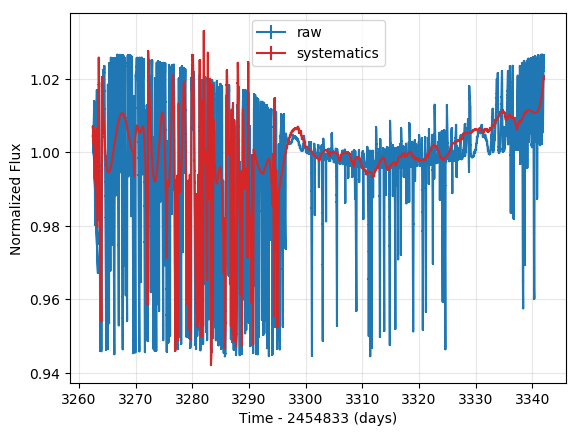

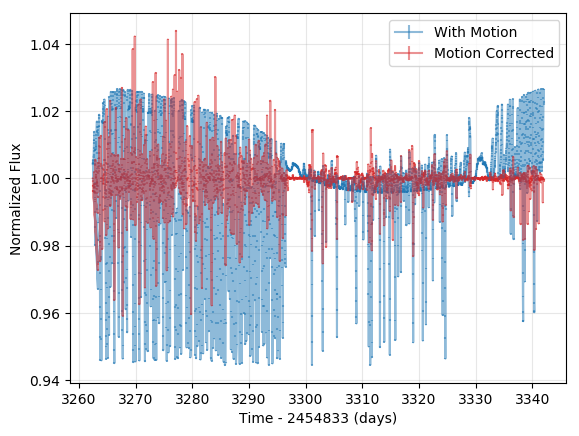

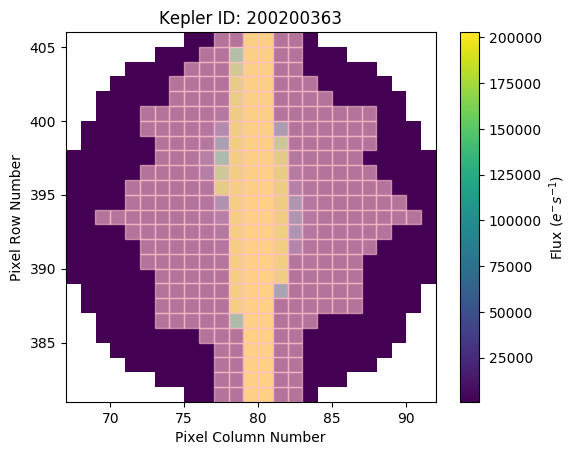

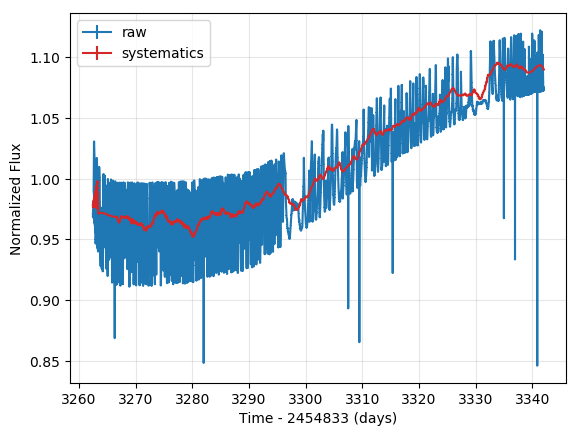

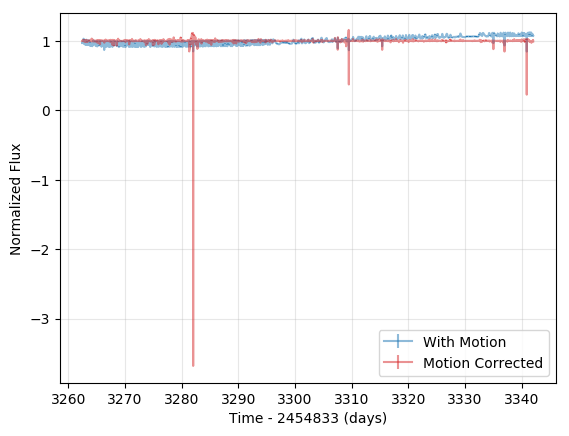

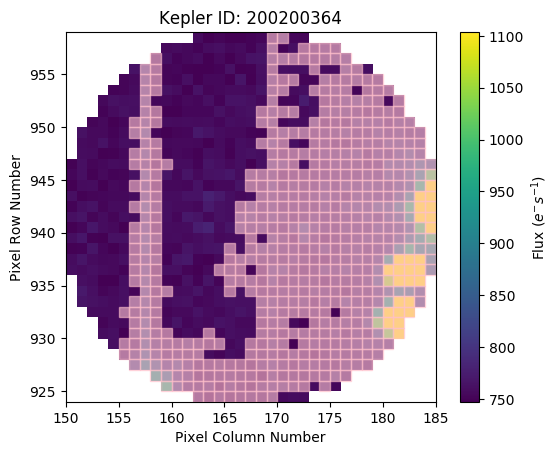

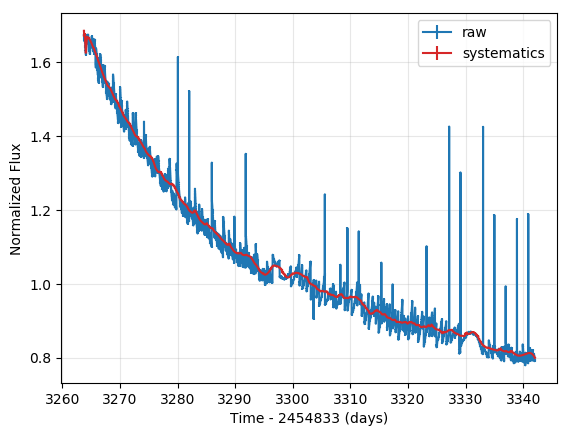

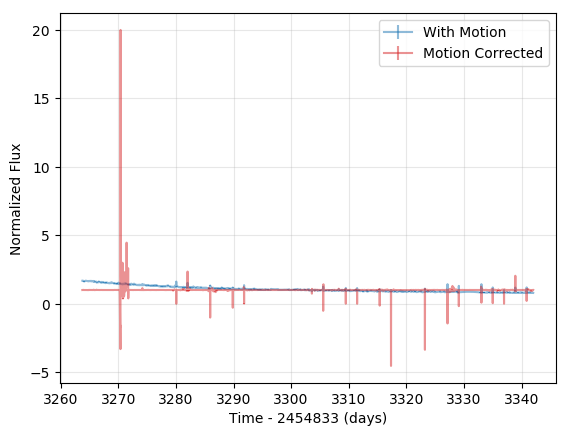

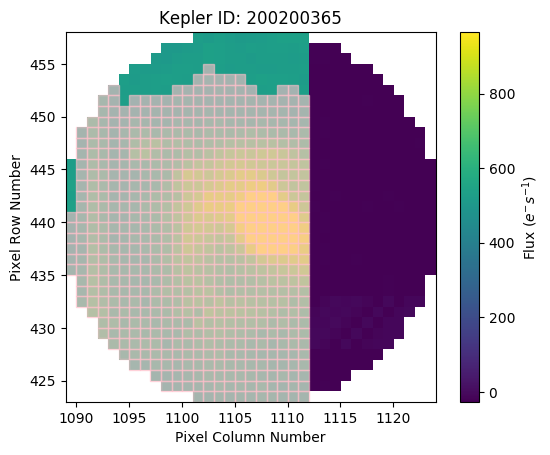

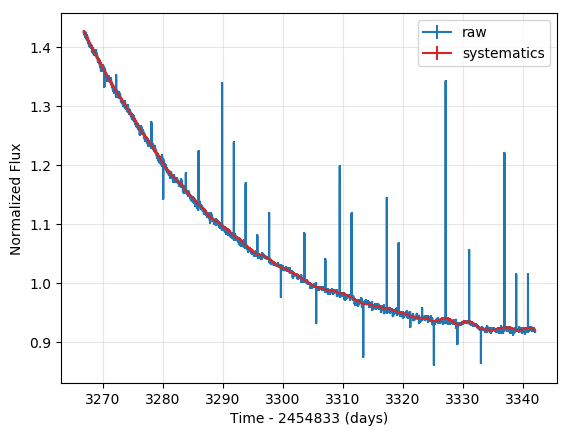

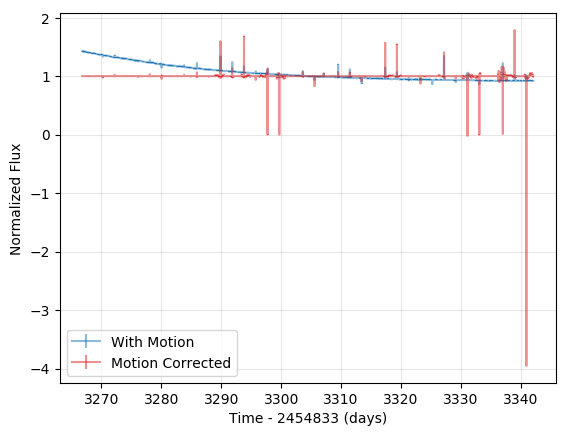

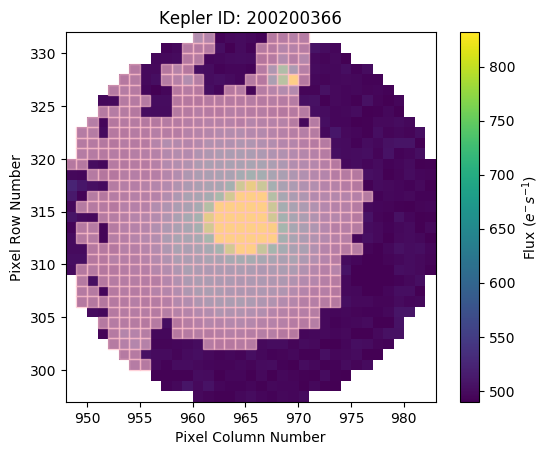

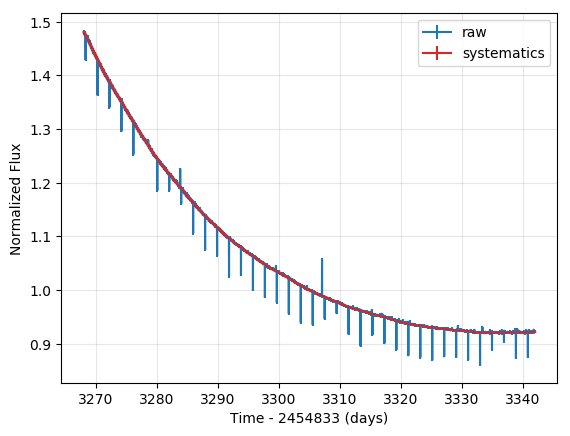

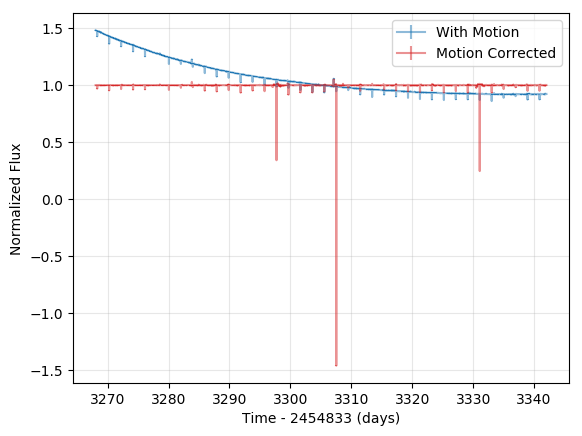

In [57]:
for i in file_list[5:]:
    try:
        #read tpf
        tpf = KeplerTargetPixelFile(i, quality_bitmask='hardest')
        #confirm aperture
        times, fluxes = tpf.time, tpf.flux
        aperture = find_aperture(times,fluxes,starname=tpf.keplerid)
        tpf.plot(aperture_mask=aperture)
        #convert to lightcurve
        lc = tpf.to_lightcurve(aperture_mask=aperture)
        #clean 
        lc = lc.remove_nans().remove_outliers(sigma=sigma)
        #correcting for low freq variability
        flat_lc, trend = lc.flatten(window_length=flat_window,
                            polyorder=polyorder,
                            break_tolerance=break_tolerance, 
                            return_trend=True)
        ax = lc.plot(color='C0', label='raw')                         
        trend.plot(ax=ax, color='C3',label='systematics');
        #correct for systematics using sff
        corr_lc = lc.correct(windows=corr_window, method='sff')
        
        #corr_lc = corr_lc.remove_outliers(sigma=10)
        #comparison
        ax2 = lc.plot(color='C0', alpha=0.5, label='With Motion')
        corr_lc.plot(ax=ax2, color='C3', alpha=0.5, label='Motion Corrected');
        
        cdpp = noise_statistic(corr_lc.time, corr_lc.flux, verbose=True)
    except:
        print(i)

In [58]:
mask = corr_lc.flux<0.5
t,f,e = corr_lc.time[~mask], corr_lc.flux[~mask], corr_lc.flux_err[~mask]

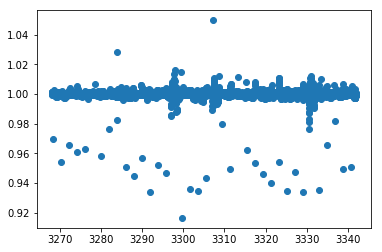

In [59]:
pl.plot(t,f,'o')

In [60]:
import gatspy
from gatspy.periodic import LombScargleFast # see also LombScargleAstroML

thin = 1
model = LombScargleFast().fit(t[::thin], f[::thin], e[::thin])
periods, power = model.periodogram_auto(nyquist_factor=100)

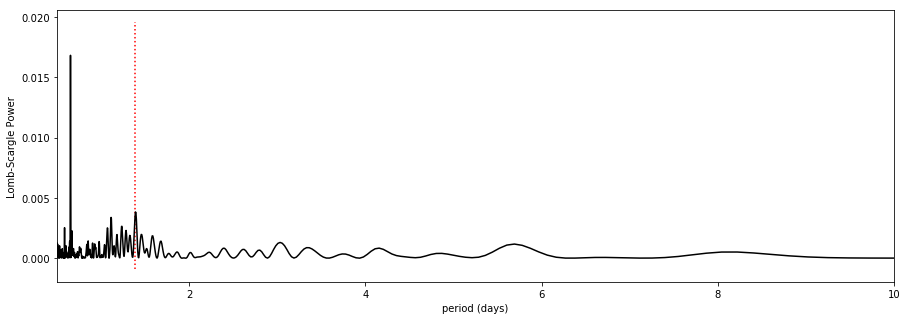

In [61]:
idx1 = periods > 1
idx2 = np.argmax(power[idx1])
peak = periods[idx1][idx2]

fig, ax = pl.subplots(1,1,figsize=(15,5))
ax.plot(periods, power, 'k-')
ax.set(xlim=(0.5, 10),
#         , ylim=(0, 0.01),
   xlabel='period (days)',
   ylabel='Lomb-Scargle Power')
ax.vlines(peak, *ax.get_ylim(), linestyles='dotted', colors='r')

In [62]:
peak

1.3909174861820568

In [63]:
#optimization
# set range and find period
model.optimizer.period_range=(2, 3)
peak = model.best_period
print("period = {0}".format(peak))

Finding optimal frequency:
 - Estimated peak width = 0.0849
 - Using 5 steps per peak; omega_step = 0.017
 - User-specified period range:  2 to 3
 - Computing periods at 63 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
period = 3.0245242265093526


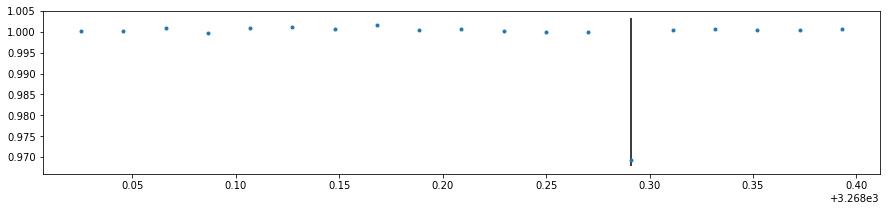

In [64]:
idx = (3268 < t) & (t < 3268.4)
tsub, fsub = t[idx], f[idx]
idx = fsub < np.median(fsub) - 0.5 * np.std(fsub)
t0 = np.median(tsub[idx])

fig, ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(tsub, fsub, '.')
ax.vlines(t0, *ax.get_ylim())

In [65]:
#import simfit
#tf, ff = simfit.util.fold(t, f, peak, t0)

def get_tns(t, p, t0):

    idx = t != 0
    t = t[idx]

    while t0-p > t.min():
        t0 -= p
    if t0 < t.min():
        t0 += p

    tns = [t0+p*i for i in range(int((t.max()-t0)/p+1))]

    while tns[-1] > t.max():
        tns.pop()

    while tns[0] < t.min():
        tns = tns[1:]

    return tns


def fold(t, f, p, t0, width=0.4, clip=False, bl=False, t14=0.2):
    tns = get_tns(t, p, t0)
    tf, ff = np.empty(0), np.empty(0)
    for i,tn in enumerate(tns):
        idx = (t > tn - width/2.) & (t < tn + width/2.)
        ti = t[idx]-tn
        fi = f[idx]
        fi /= np.nanmedian(fi)
        if bl:
            idx = (ti < -t14/2.) | (ti > t14/2.)
            assert np.isfinite(ti[idx]).all() & np.isfinite(fi[idx]).all()
            assert idx.sum() > 0
            try:
                res = sm.RLM(fi[idx], sm.add_constant(ti[idx])).fit()
                if np.abs(res.params[1]) > 1e-2:
                    print('bad data probably causing poor fit')
                    print('transit {} baseline params: {}'.format(i, res.params))
                    continue
                model = res.params[0] + res.params[1] * ti
                fi = fi - model + 1
            except:
                print("error computing baseline for transit {}".format(i))
                print("num. points: {}".format(idx.sum()))
                print(ti)
        tf = np.append(tf, ti)
        ff = np.append(ff, fi / np.nanmedian(fi))
    idx = np.argsort(tf)
    tf = tf[idx]
    ff = ff[idx]
    if clip:
        fc = sigma_clip(ff, sigma_lower=10, sigma_upper=2)
        tf, ff = tf[~fc.mask], ff[~fc.mask]
    return tf, ff

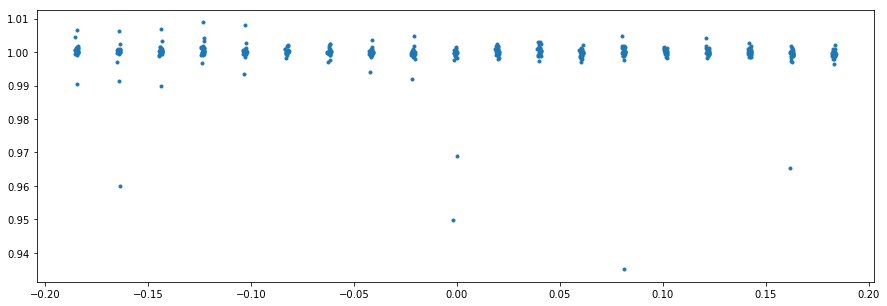

In [66]:
tf, ff = fold(t, f, peak, t0)

fig, ax = pl.subplots(1,1,figsize=(15,5))
ax.plot(tf, ff, '.')